# 2024 Deep Session 4주차

- [CNN 모델 설계](#CNN-모델-Class-(1))
- [과제](#4주차-과제)

#### 필요한 Module Import 및 변수 설정

In [2]:
''' 1. Module Import '''
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
# Batch_Size, Train_epoch 설정
BATCH_SIZE = 128
TRN_EPOCHS = 10

#### device 설정

In [4]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}") 
DEVICE = torch.device("mps")

MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? True


#### 데이터셋 다운로드 및 확인

In [6]:
''' 3. CIFAR10 데이터 다운로드(Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor()) # 이미지를 Tensor 형태로 변환(0~1)

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


------
##### Data Augmentation 기법
- `transforms.RandomHorizontalFlip()` : 해당 이미지를 50%의 확률로 좌우 반전
- `transforms.Normalize((R 평균, G 평균, B 평균), (R 표준편차, G 표준편차, B 표준편차))` : 각 채널별 이미지 픽셀 값을 채널별 평균을 뺀 뒤 표준편차로 나누어 계산
    - 최소값 : (0 - 0.5) / 0.5 = -1
    - 최대값 : (1 - 0.5) / 0.5 = 1

In [7]:

# 데이터 다운로드 시 Data Augmentation 기법 적용하기
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                                transforms.ToTensor(),
                                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


------

In [8]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([128, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([128]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

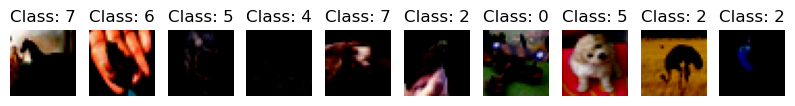

In [9]:
''' 5. 데이터 확인하기 (2) '''
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

#### 모델 설계
## CNN 모델 Class (1)

In [10]:
''' 6. Convolutional Neural Network(CNN) 모델 설계하기 (1) '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(8 * 8 * 16, 64) # 값_채우기 정답 : 8 * 8 * 16 = 1024
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

        
    def forward(self, x):
        x = self.conv1(x) # (batch_size, 3, 32, 32) -> (batch_size, 8, 32, 32)
        x = F.relu(x)
        x = self.pool(x)  # (batch_size, 8, 32, 32) -> (batch_size, 8, 16, 16)
        x = self.conv2(x) # (batch_size, 8, 16, 16) -> (batch_size, 16, 16, 16)
        x = F.relu(x)
        x = self.pool(x)  # (batch_size, 16, 16, 16) -> (batch_size, 16, 8, 8)

        x = x.view(-1, 8 * 8 * 16)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        out = F.log_softmax(x)
        return out

## CNN 모델 Class (2)

In [11]:
''' 7. Convolutional Neural Network(CNN) 모델 설계하기 (2) '''
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        
        self.feature_layer = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        
    def forward(self, x):
        x = self.feature_layer(x)

        x = x.view(-1, 1024)
        
        x = self.fc_layer(x)
        out = F.log_softmax(x)
        return out

In [12]:
# 생성한 모델 확인
model = CNN().to(DEVICE)
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


#### Optimizer, Objective Function 설정

In [13]:
''' 8. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

#### 모델 학습 및 학습 데이터의 성능 확인하는 `train` 함수 정의

In [14]:
''' 9. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()                       # 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()           # Optimizer의 Gradient를 0으로 초기화
        output = model(image)
        loss = criterion(output, label) # CrossEntropy를 이용해 Loss값 계산
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

#### 검증 데이터의 성능 확인하는 `evaluate` 함수 정의

In [15]:
''' 10. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()                          # 평가 상태로 지정
    test_loss = 0
    correct = 0                           # 올바른 Class로 평가했는지 알아보기 위해 임의 변수 설정

    with torch.no_grad():                 # Gradient를 통해 파라미터 값들이 업데이트되는 현상 방지
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()                     # test_loss값 업데이트
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item() # 예측 클래스와 실제 레이블 클래스 비교
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)                # 정확도 계산
    return test_loss, test_accuracy

#### 학습 실행 및 Loss와 Accuracy 확인

In [16]:
''' 11. CNN 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, TRN_EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 100)   # 정의한 train함수 실행
    test_loss, test_accuracy = evaluate(model, test_loader)     # 각 Epoch별로 출력되는 Loss값과 Accuracy 값 계산
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.315413
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.940032
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.561676
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.479423

[EPOCH: 1], 	Test Loss: 1.4805, 	Test Accuracy: 47.26 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.518632
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.308427
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.400152
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.369108

[EPOCH: 2], 	Test Loss: 1.3438, 	Test Accuracy: 51.94 % 

Train Epoch: 3 [0/50000 (0%)]	Train Loss: 1.382002
Train Epoch: 3 [12800/50000 (26%)]	Train Loss: 1.303008
Train Epoch: 3 [25600/50000 (51%)]	Train Loss: 1.441436
Train Epoch: 3 [38400/50000 (77%)]	Train Loss: 1.257422

[EPOCH: 3], 	Test Loss: 1.2929, 	Test Accuracy: 54.01 % 

Train Epoch: 4 [0/50000 (0%)]	Train Loss: 1.251066
Train Epoch: 4 [12800/50000 (26%)]	Train Loss: 1.335777
Train Epoch: 4 [25600/50000 (51%)]	Train Loss: 1.304389
Tra


# 4주차 과제

<span style='color:navy; font-size:18px'>  **1. [CNN 모델 설계](#CNN-모델-Class-(1))에서 각 Layer를 거친 후의 shape 주석 달아보고 코드 속 `#값_채우기`에 들어갈 값 채워보기** </span>
> Convolution의 output 크기에 대한 실습 코드입니다. 입력된 값은 위에 설계된 conv1의 설정 값들을 사용한 것으로 size를 계산할 때 활용해보세요.<br>
> `#값_채우기`에 들어갈 값은 모두 동일한 값이며 마지막 Pooling Layer를 거친 Feature의 [Channel_수 * W * H]입니다.


In [17]:
''' 1. Convolution Layer 설정 '''
# nn.Conv2d(입력채널수, 출력채널수, 커널(필터)사이즈, 등등)
conv = nn.Conv2d(3, 8, 3, padding = 1) 
print(conv)

''' 2. Input Size 설정 및 출력 '''
# 입력값의 Size와 동일한 텐서 설정 : torch.Tensor(batch_size, 채널, W, H)
conv_inputs = torch.Tensor(1, 3, 32, 32)
print(f' Input shape : {conv_inputs.shape}')

''' 3. Output Size 출력 '''
conv_out = conv(conv_inputs)
print(f'Output shape : {conv_out.shape}')

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Input shape : torch.Size([1, 3, 32, 32])
Output shape : torch.Size([1, 8, 32, 32])


> Pooling의 output 크기에 대한 실습 코드입니다. 입력된 값은 pool의 설정 값들을 사용한 것으로 size를 계산할 때 활용해보세요.


In [21]:
''' 1. Pooling Layer 설정 '''
# nn.MaxPool2d(커널(필터)사이즈, 스트라이드, 등등)
pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
print(pool2)

''' 2. Input Size 설정 및 출력 '''
# 입력값의 Size와 동일한 텐서 설정: torch.Tensor(batch_size, 채널, W, H)
pool2_inputs = torch.Tensor(1, 3, 32, 32)
print(f' Input shape : {pool2_inputs.shape}')

''' 3. Output Size 출력 '''
pool2_out = pool2(pool2_inputs)
print(f'Output shape : {pool2_out.shape}')

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 Input shape : torch.Size([1, 3, 32, 32])
Output shape : torch.Size([1, 3, 16, 16])


<span style='color:navy; font-size:18px'>  **2. Pooling 방법 변경 및 Data Augmentation 기법 적용해보며 모델 성능 비교해보기** </span>
> Pooling : https://pytorch.org/docs/stable/nn.html#pooling-layers    (*2d 함수 사용)

> Data Augmentation : https://pytorch.org/vision/stable/transforms.html#geometry

In [28]:
''' 6. Convolutional Neural Network(CNN) 모델 설계하기 (1) '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(8 * 8 * 16, 64) # 값_채우기 정답 : 8 * 8 * 16 = 1024
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

        
    def forward(self, x):
        x = self.conv1(x) # (batch_size, 3, 32, 32) -> (batch_size, 8, 32, 32)
        x = F.relu(x)
        x = self.pool(x)  # (batch_size, 8, 32, 32) -> (batch_size, 8, 16, 16)
        x = self.conv2(x) # (batch_size, 8, 16, 16) -> (batch_size, 16, 16, 16)
        x = F.relu(x)
        x = self.pool(x)  # (batch_size, 16, 16, 16) -> (batch_size, 16, 8, 8)

        x = x.view(-1, 8 * 8 * 16)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        out = F.log_softmax(x)
        return out

In [29]:
# 생성한 모델 확인
model = CNN().to(DEVICE)
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [30]:
''' 8. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [31]:
''' 9. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()                       # 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()           # Optimizer의 Gradient를 0으로 초기화
        output = model(image)
        loss = criterion(output, label) # CrossEntropy를 이용해 Loss값 계산
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [32]:
''' 10. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()                          # 평가 상태로 지정
    test_loss = 0
    correct = 0                           # 올바른 Class로 평가했는지 알아보기 위해 임의 변수 설정

    with torch.no_grad():                 # Gradient를 통해 파라미터 값들이 업데이트되는 현상 방지
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()                     # test_loss값 업데이트
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item() # 예측 클래스와 실제 레이블 클래스 비교
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)                # 정확도 계산
    return test_loss, test_accuracy

In [33]:
''' 11. CNN 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, TRN_EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 100)   # 정의한 train함수 실행
    test_loss, test_accuracy = evaluate(model, test_loader)     # 각 Epoch별로 출력되는 Loss값과 Accuracy 값 계산
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.301363
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.912112
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.868206
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.657159

[EPOCH: 1], 	Test Loss: 1.6258, 	Test Accuracy: 42.34 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.709440
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.437754
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.477698
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.401965

[EPOCH: 2], 	Test Loss: 1.4524, 	Test Accuracy: 48.62 % 

Train Epoch: 3 [0/50000 (0%)]	Train Loss: 1.259262
Train Epoch: 3 [12800/50000 (26%)]	Train Loss: 1.398360
Train Epoch: 3 [25600/50000 (51%)]	Train Loss: 1.431426
Train Epoch: 3 [38400/50000 (77%)]	Train Loss: 1.403605

[EPOCH: 3], 	Test Loss: 1.3753, 	Test Accuracy: 51.29 % 

Train Epoch: 4 [0/50000 (0%)]	Train Loss: 1.400340
Train Epoch: 4 [12800/50000 (26%)]	Train Loss: 1.347781
Train Epoch: 4 [25600/50000 (51%)]	Train Loss: 1.262779
Tra

### AvgPool 사용시 MaxPool에 비해 Test Accuracy가 감소함